In [1]:
from __future__ import (absolute_import, print_function, unicode_literals,
                        division)

import dropbot as db
import si_prefix as si

# Open DropBot connection

In [ ]:
import base_node_rpc as bnr
import base_node_rpc.proxy

try:
    proxy.terminate()
except:
    pass
proxy = db.SerialProxy(ignore=[bnr.proxy.DeviceVersionMismatch])

proxy.enable_events()

proxy.update_state(hv_output_enabled=True, hv_output_selected=True,
                   voltage=100, frequency=10e3)

# Disable channels in contact with copper tape.
disabled_channels_mask_i = proxy.disabled_channels_mask
disabled_channels_mask_i[[89, 30]] = 1
proxy.disabled_channels_mask = disabled_channels_mask_i

# Benchmark Eigen library for computing $Y = (S^T S)^{-1} S^T M$

where:

 - $S$ is a $N \times N$ switching matrix encoding the actuation state of
   each channel during each measurement window in a measuring sequence,
   such that each row of $S$ corresponds to a window within a measurement
   period and each column corresponds to a _sensitive_ channel;
 - $Y$ is a $N \times 1$ matrix encoding the electrical admittance of
   each channel (where admittance is the inverse of the impedance) during
   each measurement period;
 - $M$ is a $N \times 1$ matrix M, containing a combined measurement for
   each row in $S$, corresponding to the _actuated_ channels in the row.
   Note that $SY = M$.

Benchmarking steps:

 1. Create a representative $N \times N$ switching matrix, $S$.
 2. Create a representative electrical admittance $N \times 1$ matrix, $Y$.
 3. Compute a mock capacitance measurement $N \times 1$ matrix, $M$,
    containing simulated a combined measurement for each row in $S$,
    corresponding to the actuated channels in the row.
 4. Compute transpose of $S$.
 5. **Compute the inverse of $S_T S$** in 3 loops, repeating ``repeats``
    times in each loop and recording the duration of each loop.
 6. Return the minimum duration of a single inverse computation.


## Maximum $S$ array size

### Teensy 3.2 specifications (see [here](https://www.pjrc.com/teensy/teensy31.html#specs))

| Feature | Value | units  |
|---------|-------|--------|
| RAM     |   64  | kbytes |

As of `v1.48.1` (no Eigen matrices yet), available RAM is $\approx 44~kbytes$.  For info on calculating heap size, see [here](https://forum.pjrc.com/threads/25676-Teensy-3-how-to-know-RAM-usage?p=46762&viewfull=1#post46762).

Through empirical testing using `proxy._benchmark_eigen_inverse_float` and
`proxy._benchmark_eigen_inverse_double`:
 - **maximum size of $S$ is**:
   * **~50x50** when using `float` types for `Y` and `M`.
   * **~40x40** when using `double` types for `Y` and `M`.
 - **$(S^T S)^{-1}$ computation time** is **$\approx 5~µs$**

**In practice, this means that the number of _sensitive_ channels may be limited to $\le 50$.**

In [ ]:
print('Inverse of $S_T S$ (float) took: {}s'
      .format(si.si_format(proxy._benchmark_eigen_inverse_float(40, 100))))
print('Inverse of $S_T S$ (double) took: {}s'
      .format(si.si_format(proxy._benchmark_eigen_inverse_double(40, 100))))

## Matrix shapes

The following are the sizes of the matrices in the equation $Y = (S^T S)^{-1} S^T M$:

$
\begin{array}{}
S&: p \times n \\
S^T&: n \times p \\
Y&: n \times 1 \\
M&: n \times 1 \\
\left(S^T S\right)&: n \times n \\
\left(S^T S\right)^{-1}&: n \times n \\
\left(S^T S\right)^{-1} S^T&: n \times p \\
\end{array}
$

In [2]:
import numpy as np
from IPython.display import display


N = 10
P = 2 * N


def _NP(v):
    if v == N:
        return 'N'
    elif v == P:
        return 'P'
    return v


S = np.ones((P, N))

np.fill_diagonal(S, 0)
for i in range(1, 3):
    S[N - i, -i] = 1
    S[-i, -i] = 0
np.random.seed(0)
display(S)

Y = np.random.rand(S.shape[1])
print('Y.shape = {}'.format(tuple(map(_NP, Y.shape))))

M = S.dot(Y)
print('M.shape = {}'.format(tuple(map(_NP, M.shape))))

S_T_S = S.T.dot(S)
print('S_T_S.shape = {}'.format(tuple(map(_NP, S_T_S.shape))))
S_TS_INV = np.linalg.inv(S_T_S)
print('S_TS_INV.shape = {}'.format(tuple(map(_NP, S_TS_INV.shape))))
Y_result = S_TS_INV.dot(S.T).dot(M)

S_TS_INV_S_T = S_TS_INV.dot(S.T)
print('S_TS_INV_S_T.shape = {}'.format(tuple(map(_NP, S_TS_INV_S_T.shape))))

np.allclose(Y_result, Y)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

Y.shape = (u'N',)
M.shape = (u'P',)
S_T_S.shape = (u'N', u'N')
S_TS_INV.shape = (u'N', u'N')
S_TS_INV_S_T.shape = (u'N', u'P')


True

# Actuation levels for _sensitive_ channels

For each _sensitive_ electrode, actuation duty cycle can be in the range
$\left[\frac{1}{p}, \frac{p - 1}{p}, \right]$, where $p$ is the number of rows in the switching matrix, $n$ is the number of _sensitive_ channels, and $p \ge n$.

Increasing $p$ can:

 - Reduce the minimum actuation time for sensitive channels
 - Increase the actuation level resolution

## _Sensitive_ channel $S$ column calculation

Let $c_i$ denote the $i^{th}$ column in $S$.

Let $d_i \in [0, 1]$ denote the target duty cycle for the $i^{th}$ sensitive channel.

Let $f(d, p) = \max\left(1, \min\left(dp, p-1\right)\right)$, and $a_i = f(d_i, p)$.

$
\begin{equation*}
c_{i,j} =
\begin{cases}
  1 &\text{if $i = j$ and $a_i \lt i$,} \\
  0 &\text{if $i = j$ and $a_i \ge i$,} \\
  1 &\text{if $i \le a_i = 1$ and $j \le a_i$,} \\
  0 &\text{if $j \ge a_i - 1$,} \\
  1 &\text{otherwise}
\end{cases}
\end{equation*}
$

In [3]:
def a(d, p):
    return int(max(1, min(np.round(d * p), p - 1)))


def c(i, d_i, P):
    a_i = a(d_i, P)

    def c_(j):
        if i == j:
            return 1 if a_i < i else 0
        elif i <= a_i and j <= a_i:
            return 1
        elif j >= a_i - 1:
            return 0
        else:
            return 1
    return [c_(j) for j in range(P)]

In [4]:
import pandas as pd


print('P = {}'.format(P))


def S_(channel_levels, p=None):
    if p is None:
        p = len(channel_levels)
    return np.column_stack([c(i, d_i, p)
                            for i, d_i in channel_levels.iteritems()])

channel_levels = pd.Series(np.linspace(.1, 1, 10), index=np.arange(10))
S = S_(channel_levels, P)

Y = np.random.rand(S.shape[1])
print('Y.shape = {}'.format(tuple(map(_NP, Y.shape))))

M = S.dot(Y)
print('M.shape = {}'.format(tuple(map(_NP, M.shape))))

S_T_S = S.T.dot(S)
print('S_T_S.shape = {}'.format(tuple(map(_NP, S_T_S.shape))))
S_TS_INV = np.linalg.inv(S_T_S)
print('S_TS_INV.shape = {}'.format(tuple(map(_NP, S_TS_INV.shape))))
Y_result = S_TS_INV.dot(S.T).dot(M)

S_TS_INV_S_T = S_TS_INV.dot(S.T)
print('S_TS_INV_S_T.shape = {}'.format(tuple(map(_NP, S_TS_INV_S_T.shape))))

np.allclose(Y_result, Y)
display(Y)

P = 20
Y.shape = (u'N',)
M.shape = (u'P',)
S_T_S.shape = (u'N', u'N')
S_TS_INV.shape = (u'N', u'N')
S_TS_INV_S_T.shape = (u'N', u'P')


array([0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
       0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215])

## Plot switching matrix

In [5]:
%matplotlib inline

import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker


def plot_switching_matrix(S, axis=None):
    df_S = pd.DataFrame(S)

    patterns = it.cycle(('-', '+', 'x', '\\', '*',
                         'o', 'O', '.', '/'))
    if axis is None:
        fig, axis = plt.subplots()

    offsets = []
    for j, c_j in df_S.iteritems():
        color_j = axis._get_lines.prop_cycler.next().get('color')

        channel_scale = 1
        channel_offset = 1
        channel_count = df_S.shape[1]
        channel_fraction = 0.5

        offset = channel_scale * (channel_count - j - 1) + channel_offset
        height = channel_fraction * channel_scale
        plot_c_j = (c_j * height) + offset

        plot_c_j.plot(ax=axis, color=color_j, drawstyle='steps-post',
                      label=str(c_j.sum() / c_j.shape[0]))
        # Fill background color of plots according to feedback
        # resistor index used.
        pattern = patterns.next()

        hatch = 2 * pattern
        axis.fill_between(plot_c_j.index, plot_c_j.min(), plot_c_j,
                          step='post',
                          interpolate=True,
                          alpha=0.25,
                          edgecolor='grey',
                          facecolor=color_j, hatch=hatch)
        axis.plot(c_j.index[[0, -1]], 2 * [offset],
                  linestyle='--', color=color_j, linewidth=1)
        axis.plot(c_j.index[[0, -1]], 2 * [offset + height],
                  linestyle='--', color=color_j, linewidth=1)
        offsets.append(offset)
    axis.yaxis.set_ticks(offsets)
    axis.yaxis.set_ticklabels(map(str, df_S.columns))
    axis.set_xlabel('Window')
    axis.set_ylabel('Channel')
    axis.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    return axis

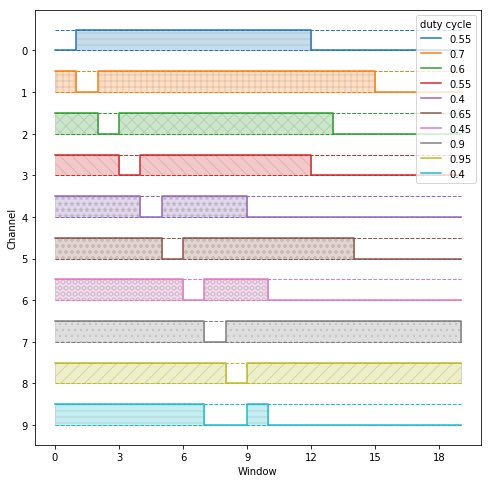

In [7]:
np.random.seed(0)
S = S_(pd.Series(np.random.rand(10)), p=20)
fig, axis = plt.subplots(1, 1, figsize=(8, 8))
axis = plot_switching_matrix(S, axis=axis)
axis.legend(loc='upper right', title='duty cycle')